# Setup & Import Libraries

In [ ]:
import os
os.chdir("../data")

In [2]:
%ls

food_c101_n1000_r384x384x3.h5       food_test_c101_n1000_r32x32x3.h5
food_c101_n10099_r32x32x1.h5        food_test_c101_n1000_r64x64x1.h5
food_c101_n10099_r32x32x3.h5        food_test_c101_n1000_r64x64x3.h5
food_c101_n10099_r64x64x1.h5        images/
food_c101_n10099_r64x64x3.h5        meta/
food_test_c101_n1000_r128x128x1.h5  test/
food_test_c101_n1000_r128x128x3.h5  train/
food_test_c101_n1000_r32x32x1.h5


In [3]:
def ensure_path(directory: str):
    if (not os.path.exists(directory)):
        os.makedirs(directory)


def data_pipeline():
    with open("meta/meta/train.txt") as trainfile:
        trainlines = trainfile.readlines()
        trainlines = [line.rstrip()+".jpg" for line in trainlines]
        
    with open("meta/meta/test.txt") as testfile:
        testlines = testfile.readlines()
        testlines = [line.rstrip()+".jpg" for line in testlines]
        
    ensure_path("train")
    ensure_path("test")
    
    with open("meta/meta/classes.txt") as classfiles:
        classlines = classfiles.readlines()
        classlines = [line.rstrip() for line in classlines]
    
    for class_ in classlines:
        try:
            os.makedirs("train/"+class_)
        except:
            pass
        try:
            os.makedirs("test/"+class_)
        except:
            pass
        
    for t1 in trainlines:
        try:
            os.replace("images/"+t1, "train/"+t1)
        except:
            pass
    
    for t1 in testlines:
        try:
            os.replace("images/"+t1, "test/"+t1)
        except:
            pass

In [5]:
data_pipeline()

In [6]:
%ls

food_c101_n1000_r384x384x3.h5       food_test_c101_n1000_r32x32x3.h5
food_c101_n10099_r32x32x1.h5        food_test_c101_n1000_r64x64x1.h5
food_c101_n10099_r32x32x3.h5        food_test_c101_n1000_r64x64x3.h5
food_c101_n10099_r64x64x1.h5        images/
food_c101_n10099_r64x64x3.h5        meta/
food_test_c101_n1000_r128x128x1.h5  test/
food_test_c101_n1000_r128x128x3.h5  train/
food_test_c101_n1000_r32x32x1.h5


In [7]:
import os
os.chdir("../")
%ls

a  data/  kaggle.json  notebooks/  reports/


In [5]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
tf.random.set_seed(42)

# Exploratory Data Analysis - EDA

In [5]:
def get_labels(path: str):
    labels = {}
    for root, dirs, files in os.walk(path, topdown=False):
        print(f"Get {root.split('/')[-1]} labels ({root.split('/')[-2]} set)")
        with tqdm(total=len(files)) as pbar:
            if (len(files)>0):
                n_labels = len(files)
                labels[root.split('/')[-1]] = n_labels
                pbar.update(len(files))
    
    return labels


def get_train_val_labels(data_path: str):
    train_labels = get_labels(os.path.join(data_path, "train"))
    val_labels = get_labels(os.path.join(data_path, "test"))
    labels = {
        "train": train_labels,
        "test": val_labels,
    }
    return labels

In [ ]:
data_path= "data"
labels = get_train_val_labels(data_path)

In [7]:
df = pd.DataFrame(labels)
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'classes'})
df.head()

,classes,train,test
0,fish_and_chips,750,250
1,beet_salad,750,250
2,caesar_salad,750,250
3,churros,750,250
4,poutine,750,250


In [8]:
def plot_class_distribution(figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title("Amount of Train Set Split for Labels")
    sns.barplot(data=df, x="classes", y="train")
    plt.show()

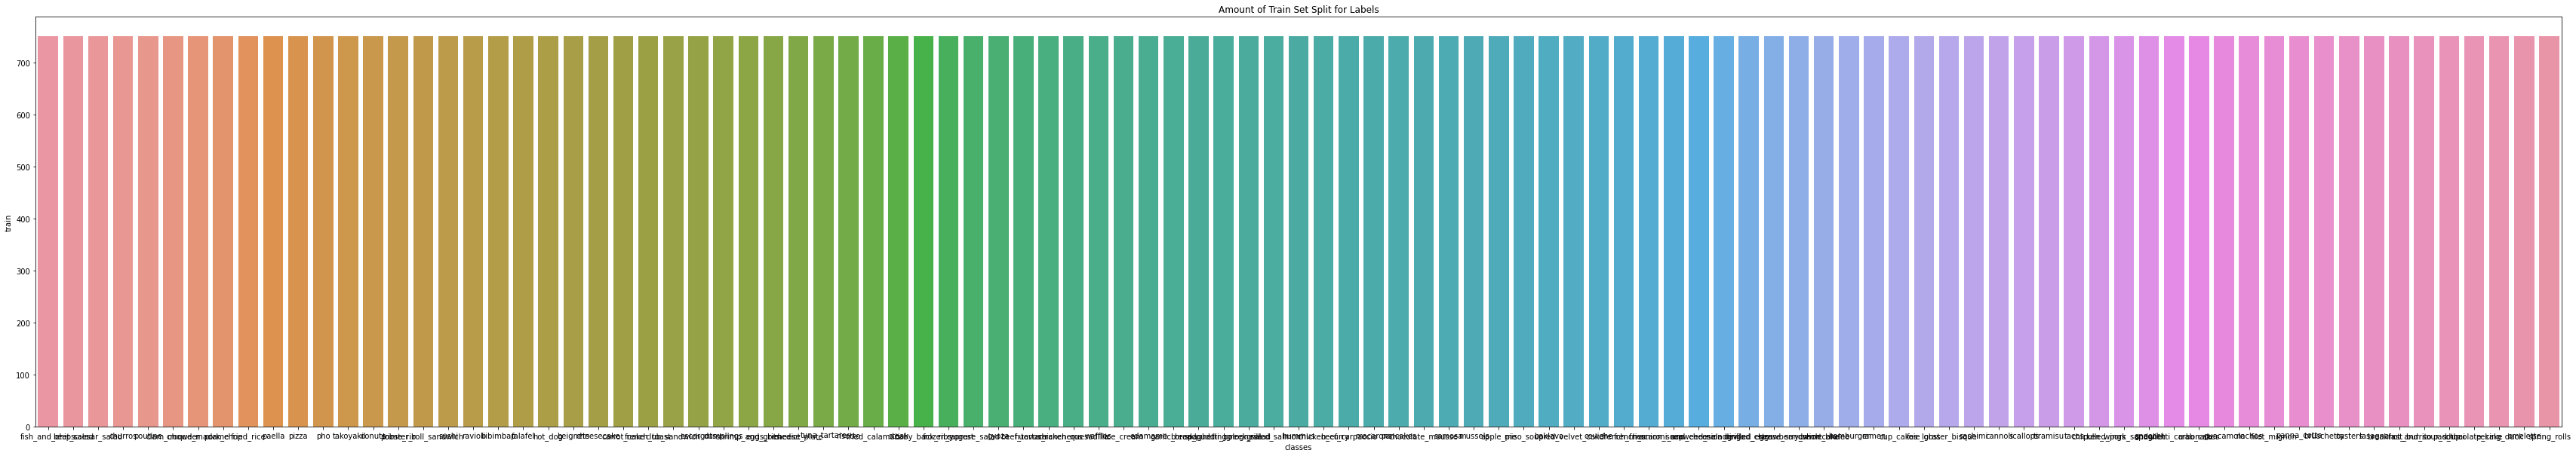

In [9]:
plot_class_distribution(figsize=(60,10)) # we have a balanced dataset

# Data Preprocessing and Augmentation

In [10]:
train_path = "data/train/"
test_path = "data/test/"

In [11]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='reflect',
    zoom_range=[.8, 1],
    channel_shift_range=30,
)

In [12]:
batch_size=32
image_size = (256, 256)
train_dataset = image_generator.flow_from_directory(
    directory=train_path,
    batch_size=batch_size,
    shuffle=True,
    target_size=image_size,
    subset="training",
    class_mode="categorical"
)
validation_dataset = image_generator.flow_from_directory(
    directory=train_path,
    batch_size=batch_size,
    shuffle=False,
    target_size=image_size,
    subset="validation",
    class_mode="categorical"
)

Found 68175 images belonging to 101 classes.
Found 7575 images belonging to 101 classes.


# Build CNN Inception Custom Model

In [13]:
class BuildCNNModel(HyperModel):
    def __init__(self, shape: tuple, n_classes=101):
        self.shape = shape
        self.n_classes = n_classes
    
    def conv2d_bn(self, x, filters, kernel, padding="same", strides=(1,1)):
        x = layers.Conv2D(filters, kernel, padding=padding, strides=strides)(x)
        x = layers.BatchNormalization(axis=3, scale=False)(x)
        x = layers.Activation("relu")(x)
        return x
        
    
    def get_model(self):
        input = keras.Input(shape=self.shape)
        
        x = self.conv2d_bn(input, 32, (3,3), strides=(2,2), padding="valid")
        x = self.conv2d_bn(x, 32, (3,3), strides=(2,2), padding="valid")
        x = self.conv2d_bn(x, 64, (3,3))
        x = layers.MaxPooling2D((3,3), strides=(2,2))(x)
        
        # mixed 0: 35 x 35 x 256
        branch1x1 = self.conv2d_bn(x, 64, (1, 1))

        branch5x5 = self.conv2d_bn(x, 48, (1, 1))
        branch5x5 = self.conv2d_bn(branch5x5, 64, (5, 5))

        branch3x3dbl = self.conv2d_bn(x, 64, (1, 1))
        branch3x3dbl = self.conv2d_bn(branch3x3dbl, 96, (3, 3))
        branch3x3dbl = self.conv2d_bn(branch3x3dbl, 96, (3, 3))

        branch_pool = layers.AveragePooling2D((3, 3),
                                              strides=(1, 1),
                                              padding='same')(x)
        branch_pool = self.conv2d_bn(branch_pool, 32, (1, 1))
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=3,
            name='mixed0')
        
        # mixed 2: 35 x 35 x 288
        branch1x1 = self.conv2d_bn(x, 64, (1, 1))

        branch5x5 = self.conv2d_bn(x, 48, (1, 1))
        branch5x5 = self.conv2d_bn(branch5x5, 64, (5, 5))

        branch3x3dbl = self.conv2d_bn(x, 64, (1, 1))
        branch3x3dbl = self.conv2d_bn(branch3x3dbl, 96, (3, 3))
        branch3x3dbl = self.conv2d_bn(branch3x3dbl, 96, (3, 3))

        branch_pool = layers.AveragePooling2D((3, 3),
                                              strides=(1, 1),
                                              padding='same')(x)
        branch_pool = self.conv2d_bn(branch_pool, 64, (1, 1))
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=3,
            name='mixed2')
        
        # mixed 3: 17 x 17 x 768
        branch3x3 = self.conv2d_bn(x, 384, (3, 3), strides=(2, 2), padding='valid')

        branch3x3dbl = self.conv2d_bn(x, 64, (1, 1))
        branch3x3dbl = self.conv2d_bn(branch3x3dbl, 96, (3, 3))
        branch3x3dbl = self.conv2d_bn(
            branch3x3dbl, 96, (3, 3), strides=(2, 2), padding='valid')

        branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate(
            [branch3x3, branch3x3dbl, branch_pool],
            axis=3,
            name='mixed3')
        
        x = layers.GlobalAveragePooling2D()(x)
        # x = layers.GlobalMaxPooling2D()(x)
        x = layers.Dense(512, activation="relu", name="fc1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
        # x = layers.Dropout(0.5)(x)
        # x = layers.Dense(512, activation="relu", name="fc2")(x)
        
        output = keras.layers.Dense(self.n_classes, activation="softmax", name="predictions")(x)
        model = keras.Model(inputs=input, outputs=output, name="inception_custom")  
      
        lr = 5e-4
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        metrics = [
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ]
        model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=metrics)
        return model

In [14]:
shape = image_size+(3,)
hm = BuildCNNModel(shape)

In [16]:
model = hm.get_model()
model.summary()

Model: "inception_custom"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 127, 127, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 127, 127, 32  96         ['conv2d_21[0][0]']              
 ormalization)                  )                                                  

# Train Base Model

In [87]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, mode="max"),
    keras.callbacks.ModelCheckpoint("reports/cnn_inception_custom_mixed_3/model_{epoch}.h5", monitor='val_accuracy', mode="max", verbose=1, save_best_only=True),
]

In [80]:
history = model.fit(
    train_dataset,
    steps_per_epoch=68175 // batch_size,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=7575 // batch_size,
    callbacks=callbacks
)

Epoch 1/100
2130/2130 [==============================] - ETA: 0s - loss: 4.1512 - accuracy: 0.0909
Epoch 1: val_loss improved from inf to 4.09333, saving model to reports/cnn_inception_custom_mixed_3/model_1.h5
2130/2130 [==============================] - 677s 317ms/step - loss: 4.1512 - accuracy: 0.0909 - val_loss: 4.0933 - val_accuracy: 0.0975 - lr: 5.0000e-04
Epoch 2/100
2130/2130 [==============================] - ETA: 0s - loss: 3.5677 - accuracy: 0.1728
Epoch 2: val_loss improved from 4.09333 to 3.56206, saving model to reports/cnn_inception_custom_mixed_3/model_2.h5
2130/2130 [==============================] - 676s 318ms/step - loss: 3.5677 - accuracy: 0.1728 - val_loss: 3.5621 - val_accuracy: 0.1822 - lr: 5.0000e-04
Epoch 3/100
2130/2130 [==============================] - ETA: 0s - loss: 3.1922 - accuracy: 0.2428
Epoch 3: val_loss improved from 3.56206 to 3.38512, saving model to reports/cnn_inception_custom_mixed_3/model_3.h5
2130/2130 [==============================] - 678s 3

In [88]:
history_1 = model.fit(
    train_dataset,
    steps_per_epoch=68175 // batch_size,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=7575 // batch_size,
    callbacks=callbacks,
    initial_epoch=42
)

Epoch 43/100
2130/2130 [==============================] - ETA: 0s - loss: 1.4862 - accuracy: 0.6340
Epoch 43: val_accuracy improved from -inf to 0.60050, saving model to reports/cnn_inception_custom_mixed_3/model_43.h5
2130/2130 [==============================] - 673s 316ms/step - loss: 1.4862 - accuracy: 0.6340 - val_loss: 1.6687 - val_accuracy: 0.6005 - lr: 5.0000e-08
Epoch 44/100
2130/2130 [==============================] - ETA: 0s - loss: 1.4857 - accuracy: 0.6340
Epoch 44: val_accuracy did not improve from 0.60050
2130/2130 [==============================] - 674s 316ms/step - loss: 1.4857 - accuracy: 0.6340 - val_loss: 1.6733 - val_accuracy: 0.5956 - lr: 5.0000e-08
Epoch 45/100
2130/2130 [==============================] - ETA: 0s - loss: 1.4850 - accuracy: 0.6335
Epoch 45: val_accuracy did not improve from 0.60050
2130/2130 [==============================] - 672s 315ms/step - loss: 1.4850 - accuracy: 0.6335 - val_loss: 1.6718 - val_accuracy: 0.5948 - lr: 5.0000e-08
Epoch 46/100
21

In [131]:
model.save_weights("reports/cnn_inception_custom_mixed_3/final_model.h5")

In [17]:
model.load_weights("reports/cnn_inception_custom_mixed_3/final_model.h5")

In [103]:
def merge_history(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
            dict_3[key] = dict_1[key] + value
    return dict_3

In [104]:
final_history = merge_history(history.history, history_1.history)

In [81]:
import json
def save_json(dictionary: dict, path: str):
    for key in dictionary:
        dictionary[key] = [float(v) for v in dictionary[key]]
    json_object = json.dumps(dictionary, indent=4)
 
    with open(path, "w") as outfile:
        outfile.write(json_object)

In [130]:
save_json(final_history, "reports/cnn_custom_inception_mixed_3.json")

In [101]:
def plot_history(history: dict, n_epochs=53):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,3)
    train_acc = history["accuracy"]
    train_loss = history["loss"]
    test_acc = history["val_accuracy"]
    test_loss = history["val_loss"]
    lr = history["lr"]
    
    fig.set_size_inches(30,12)
    ax[0].plot(epochs, train_loss, label="Training Loss")
    ax[0].plot(epochs, test_loss, label="Testing Loss")
    ax[0].set_title("Training & Testing Loss")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs, train_acc, label="Training Accuracy")
    ax[1].plot(epochs, test_acc, label="Testing Accuracy")
    ax[1].set_title("Training & Testing Accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    
    ax[2].plot(epochs, lr, label="Learning Rate")
    ax[2].set_title("Learning Rate Schedule")
    ax[2].legend()
    ax[2].set_xlabel("Epochs")
    plt.show()

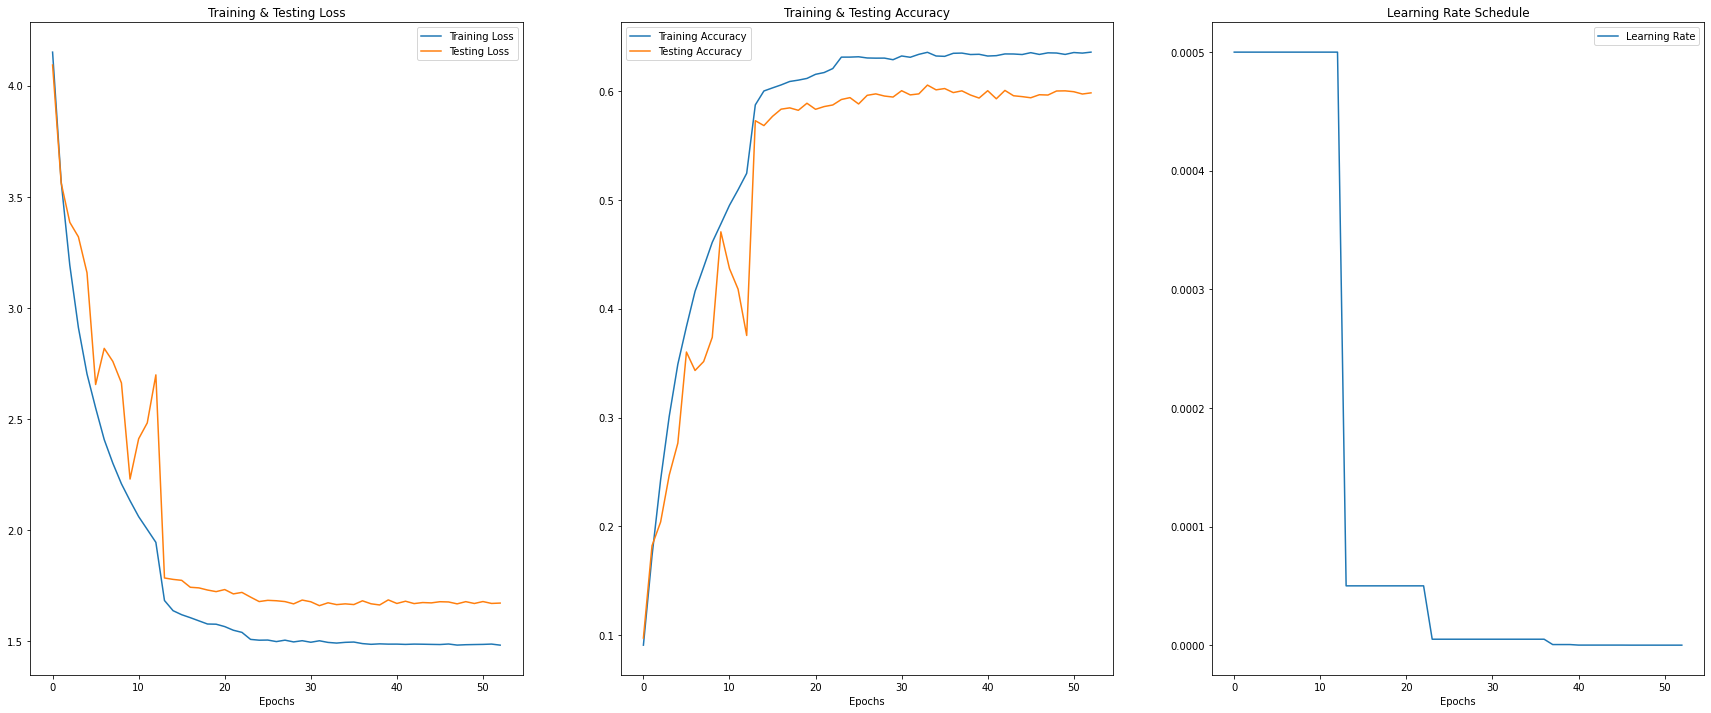

In [105]:
plot_history(final_history)

# Evaluate 

In [18]:
test_path = "data/test"

In [19]:
test_generator = ImageDataGenerator(
    rescale=1./255,
)
test_dataset = test_generator.flow_from_directory(
    directory=test_path,
    batch_size=batch_size,
    shuffle=False,
    target_size=image_size,
    class_mode="categorical"
)

Found 25250 images belonging to 101 classes.


In [21]:
loss, accuracy = model.evaluate(test_dataset)
print(f"loss: {loss}, accuracy: {accuracy}")

790/790 [==============================] - 33s 42ms/step - loss: 1.3742 - accuracy: 0.6566
loss: 1.3741596937179565, accuracy: 0.6566336750984192


In [49]:
y_test = test_dataset.classes

In [23]:
pred = model.predict(test_dataset)

790/790 [==============================] - 37s 46ms/step


In [36]:
y_pred = np.argmax(pred, axis=1)

In [50]:
y_test[1], y_pred[1]

(0, 81)

In [55]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 61,   0,  24, ...,   4,   0,   5],
       [  0, 148,   2, ...,   0,   0,   2],
       [ 10,   0, 186, ...,   1,   0,   1],
       ...,
       [  2,   0,   2, ..., 164,   1,   1],
       [  0,   1,   0, ...,   0, 131,   0],
       [  2,   0,   0, ...,   2,   0, 178]])

<AxesSubplot: >

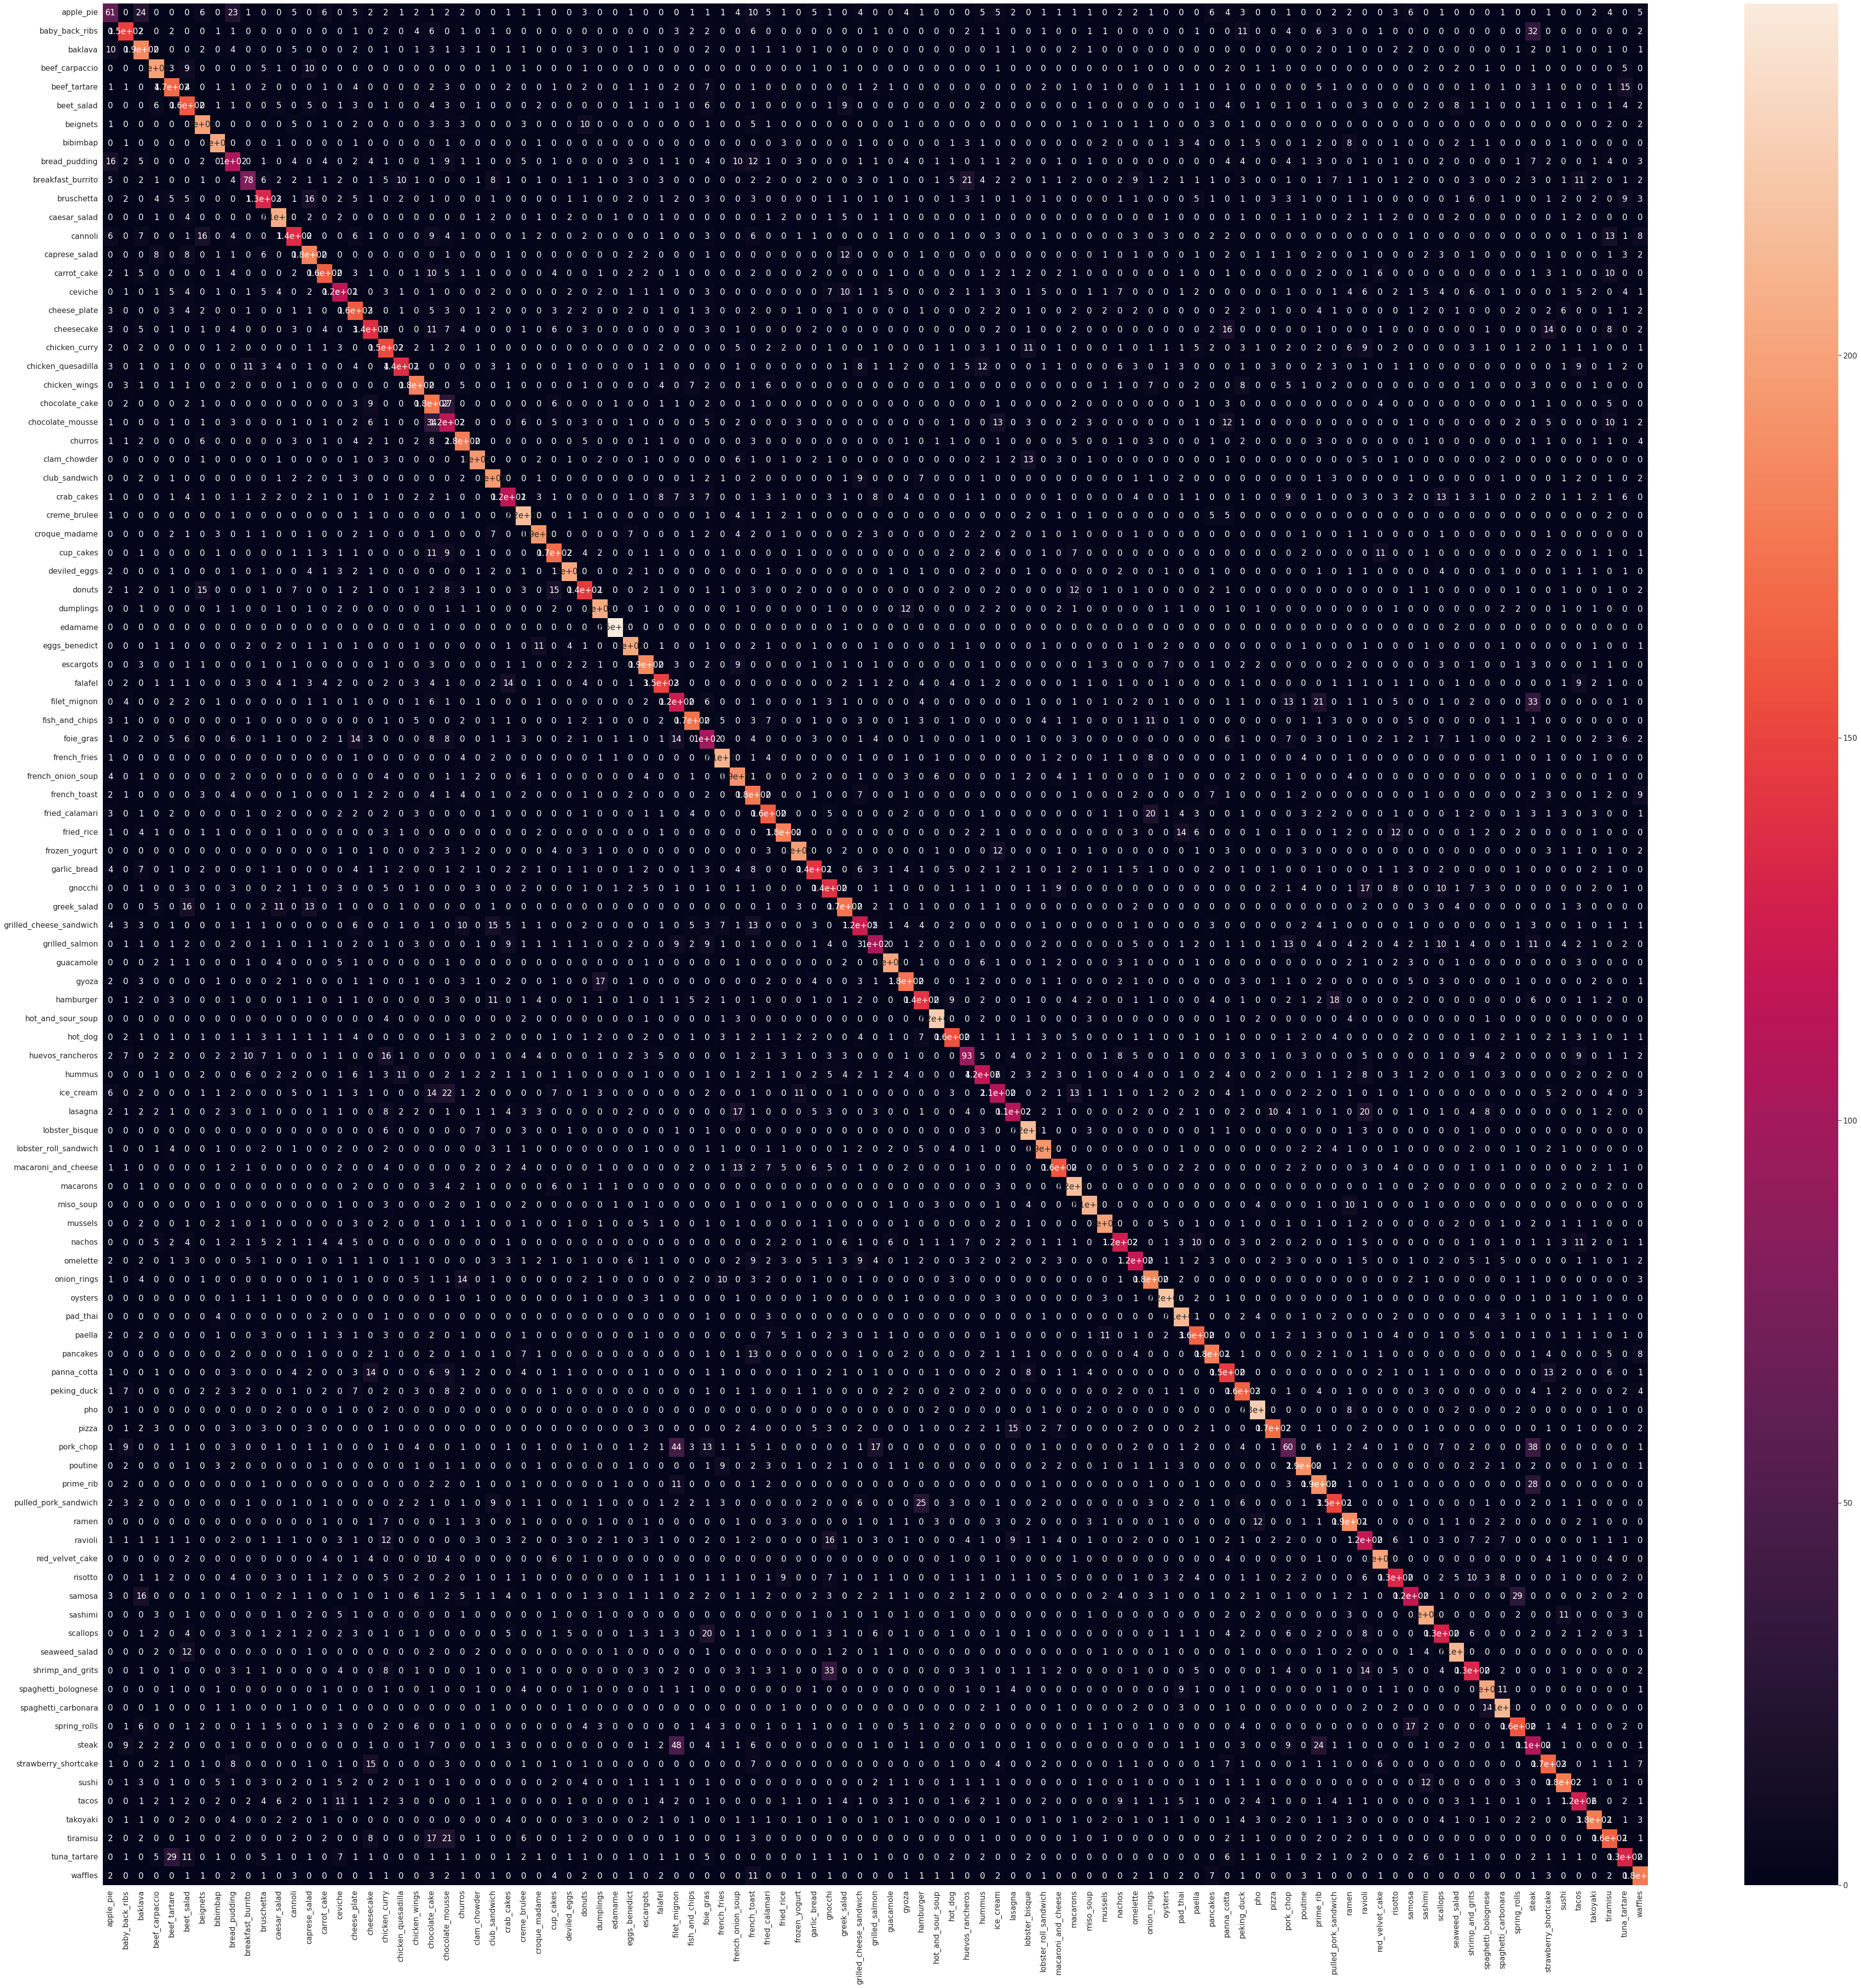

In [61]:
name_labels = list(test_dataset.class_indices.keys())
df_cm = pd.DataFrame(cm, index = [i for i in name_labels],
                  columns = [i for i in name_labels])
plt.figure(figsize = (70,70))
sns.heatmap(df_cm, annot=True)